In [1]:
# mnist_cnn.py
# PyTorch 1.10.0-CPU Anaconda3-2020.02  Python 3.7.6
# Windows 10 

# reads MNIST data from text file rather than using
# built-in black box Dataset from torchvision

import numpy as np
import matplotlib.pyplot as plt
import torch as T
import os

print(os.getcwd())

device = T.device('cpu')

/content


In [2]:
# -----------------------------------------------------------

class MNIST_Dataset(T.utils.data.Dataset):
  # 784 tab-delim pixel values (0-255) then label (0-9)
  def __init__(self, src_file):
    all_xy = np.loadtxt(src_file, usecols=range(785),
      delimiter=",", comments="#", dtype=np.float32)

    tmp_x = all_xy[:, 0:784]  # all rows, cols [0,783]
    tmp_x /= 255
    tmp_x = tmp_x.reshape(-1, 1, 28, 28)  # bs, chnls, 28x28
    tmp_y = all_xy[:, 784]    # 1-D required

    self.x_data = \
      T.tensor(tmp_x, dtype=T.float32).to(device)
    self.y_data = \
      T.tensor(tmp_y, dtype=T.int64).to(device) 

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    lbl = self.y_data[idx]  # no use labels
    pixels = self.x_data[idx] 
    return (pixels, lbl)

In [3]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()  # pre Python 3.3 syntax

    """self.conv1 = T.nn.Conv2d(1, 32, 5)  # chnl-in, out, krnl
    self.conv2 = T.nn.Conv2d(32, 64, 5)
    self.fc1 = T.nn.Linear(1024, 512)   # [64*4*4, x]
    self.fc2 = T.nn.Linear(512, 256)
    self.fc3 = T.nn.Linear(256, 10)     # 10 classes
    self.pool1 = T.nn.MaxPool2d(2, stride=2) # kernel, stride
    self.pool2 = T.nn.MaxPool2d(2, stride=2)
    self.drop1 = T.nn.Dropout(0.25)
    self.drop2 = T.nn.Dropout(0.50)"""

    self.conv1 = T.nn.Conv2d(1, 1, 5)  # chnl-in, out, krnl
    self.conv2 = T.nn.Conv2d(32, 64, 5)
    #self.fc1 = T.nn.Linear(1024, 512)   # [64*4*4, x]
    #self.fc2 = T.nn.Linear(512, 256)
    #self.fc3 = T.nn.Linear(256, 10)     # 10 classes
    self.fc1 = T.nn.Linear(144, 10)   # [64*4*4, x]
    #self.fc2 = T.nn.Linear(512, 256)
    #self.fc3 = T.nn.Linear(256, 10)     # 10 classes
    self.pool1 = T.nn.MaxPool2d(2, stride=2) # kernel, stride
    self.pool2 = T.nn.MaxPool2d(2, stride=2)
    self.drop1 = T.nn.Dropout(0.25)
    self.drop2 = T.nn.Dropout(0.50)

  def print_everything(self):

    print(self.conv1.data)
    print(self.conv2)
    print(self.fc1)
    print(self.fc2)
    print(self.fc3)
  
  def forward(self, x):
    # convolution phase         # x is [bs, 1, 28, 28]
    """z = T.relu(self.conv1(x))   # Size([bs, 32, 24, 24])
    z = self.pool1(z)           # Size([bs, 32, 12, 12])
    z = self.drop1(z)
    z = T.relu(self.conv2(z))   # Size([bs, 64, 8, 8])
    z = self.pool2(z)           # Size([bs, 64, 4, 4])
   
    # neural network phase
    z = z.reshape(-1, 1024)     # Size([bs, 1024])
    z = T.relu(self.fc1(z))     # Size([bs, 512])
    z = self.drop2(z)
    z = T.relu(self.fc2(z))     # Size([bs, 256])
    z = self.fc3(z)             # Size([bs, 10])"""

    # convolution phase         # x is [bs, 1, 28, 28]
    z = T.relu(self.conv1(x))   # Size([bs, 1, 24, 24])
    z = self.pool1(z)           # Size([bs, 1, 12, 12])
    #z = self.drop1(z)
    #z = T.relu(self.conv2(z))   # Size([bs, 64, 8, 8])
    #z = self.pool2(z)           # Size([bs, 64, 4, 4])
   
    # neural network phase
    z = z.reshape(-1, 144)     # Size([bs, 144])
    #z = T.relu(self.fc1(z))     # Size([bs, 10])
    z = self.fc1(z)     # Size([bs, 10])
    #z = self.drop2(z)
    #z = T.relu(self.fc2(z))     # Size([bs, 256])
    #z = self.fc3(z)             # Size([bs, 10])
    return z

In [4]:
def accuracy(model, ds):
  ldr = T.utils.data.DataLoader(ds,
    batch_size=len(ds), shuffle=False)
  n_correct = 0
  for data in ldr:
    (pixels, labels) = data
    with T.no_grad():
      oupts = model(pixels)
    (_, predicteds) = T.max(oupts, 1)
    n_correct += (predicteds == labels).sum().item()
    print(predicteds)

  acc = (n_correct * 1.0) / len(ds)
  return acc

In [5]:
def main():
  # 0. setup
  print("\nBegin MNIST with CNN demo ")
  np.random.seed(1)
  T.manual_seed(1)

In [6]:
  # 1. create Dataset
  print("\nCreating 1000-item train Dataset from text file ")
  train_file = "./sample_data/mnist_train_1000.txt"
  train_ds = MNIST_Dataset(train_file)


Creating 1000-item train Dataset from text file 


In [7]:
  bat_size = 10
  train_ldr = T.utils.data.DataLoader(train_ds,
    batch_size=bat_size, shuffle=True)

  # 2. create network
  print("\nCreating CNN network with 1 conv and 1 linear ")
  net = Net().to(device)


Creating CNN network with 1 conv and 1 linear 


In [8]:
  # 3. train model
  max_epochs = 50  # 100 gives better results
  ep_log_interval = 5
  lrn_rate = 0.005
  
  loss_func = T.nn.CrossEntropyLoss()  # does log-softmax()
  optimizer = T.optim.SGD(net.parameters(), lr=lrn_rate)
  
  print("\nbat_size = %3d " % bat_size)
  print("loss = " + str(loss_func))
  print("optimizer = SGD")
  print("max_epochs = %3d " % max_epochs)

  print("lrn_rate = %0.3f " % lrn_rate)


bat_size =  10 
loss = CrossEntropyLoss()
optimizer = SGD
max_epochs =  50 
lrn_rate = 0.005 


In [9]:
  print("\nStarting training")
  net.train()  # set mode
  for epoch in range(0, max_epochs):
    ep_loss = 0  # for one full epoch
    for (batch_idx, batch) in enumerate(train_ldr):
      (X, y) = batch  # X = pixels, y = target labels
      optimizer.zero_grad()
      oupt = net(X)
      loss_val = loss_func(oupt, y)  # a tensor
      #print("The output is ")
      #print(oupt)
      #print(y)
      ep_loss += loss_val.item()  # accumulate
      loss_val.backward()  # compute grads
      optimizer.step()     # update weights
    if epoch % ep_log_interval == 0:
      print("epoch = %4d   loss = %0.4f" % (epoch, ep_loss))

  print("Done ") 


Starting training
epoch =    0   loss = 230.3140
epoch =    5   loss = 146.8176
epoch =   10   loss = 48.9457
epoch =   15   loss = 37.3201
epoch =   20   loss = 32.0552
epoch =   25   loss = 29.0123
epoch =   30   loss = 26.0886
epoch =   35   loss = 24.4442
epoch =   40   loss = 22.4409
epoch =   45   loss = 20.7928
Done 


In [10]:
  # 4. evaluate model accuracy
  print("\nComputing model accuracy")
  net.eval()
  #T.set_printoptions(linewidth=10)
  print("The convolution weight is : ")
  print(net.conv1.weight)
  print("The linear weight is : ")
  #print(loaded_matrix)
  print(net.fc1.weight)
  weight_matrix = net.fc1.weight.T.detach().numpy()
  for i in range(144):
    for j in range(10):
        print(weight_matrix[i][j], end=' ')
    print()
  acc_train = accuracy(net, train_ds)  # all at once

  print("Accuracy on training data = %0.4f" % acc_train)


Computing model accuracy
The convolution weight is : 
Parameter containing:
tensor([[[[ 0.3914,  0.3111,  0.7927,  0.7223,  0.9370],
          [ 0.2425,  0.4552,  0.8965,  0.9039,  1.0564],
          [-0.1454,  0.3218,  0.6565,  0.8154,  0.6088],
          [-0.1639,  0.1987,  0.3324,  0.1958,  0.2762],
          [-0.3905, -0.0256,  0.1656,  0.0082, -0.0591]]]], requires_grad=True)
The linear weight is : 
Parameter containing:
tensor([[ 0.0759, -0.0605,  0.0498,  ...,  0.0070, -0.0454, -0.0520],
        [-0.0402,  0.0287, -0.0433,  ..., -0.0223, -0.0551, -0.0084],
        [ 0.0120, -0.0228, -0.0687,  ...,  0.0653, -0.0020, -0.0703],
        ...,
        [-0.0458, -0.0200,  0.0353,  ..., -0.1573, -0.0829,  0.0136],
        [-0.0637, -0.0162,  0.0690,  ...,  0.0735, -0.0811,  0.0314],
        [ 0.0171, -0.0140, -0.0300,  ...,  0.1415,  0.0760,  0.0286]],
       requires_grad=True)
0.07585539 -0.0401862 0.011950545 -0.054809995 -0.0005036357 0.010673035 -0.059212316 -0.04583555 -0.0636783

In [11]:
  test_file = "./sample_data/mnist_test_100.txt"
  test_ds = MNIST_Dataset(test_file)
  net.eval()
  acc_test = accuracy(net, test_ds)  # all at once
  print("Accuracy on test data = %0.4f" % acc_test)

tensor([0, 7, 1, 1, 3, 9, 4, 3, 4, 8, 2, 2, 1, 8, 7, 0, 8, 1, 0, 0, 6, 3, 7, 7,
        4, 8, 8, 9, 2, 0, 6, 1, 7, 2, 2, 9, 9, 4, 9, 5, 0, 6, 7, 7, 1, 8, 0, 7,
        2, 0, 4, 1, 1, 2, 7, 5, 9, 7, 8, 8, 1, 9, 5, 8, 8, 1, 9, 8, 3, 1, 1, 5,
        7, 4, 2, 4, 7, 3, 0, 1, 1, 1, 7, 0, 1, 1, 8, 5, 9, 5, 0, 6, 6, 0, 4, 1,
        2, 2, 4, 4])
Accuracy on test data = 0.8300


In [12]:
  # 5. make a prediction
  print("\nMaking prediction for fake image: ")
  x = np.zeros(shape=(28,28), dtype=np.float32)
  for row in range(5,23):
    x[row][9] = 180  # vertical line
  for rc in range(9,19):
    x[rc][rc] = 250  # diagonal
  for col in range(5,15):  
    x[14][col] = 200  # horizontal
  x /= 255.0


Making prediction for fake image: 


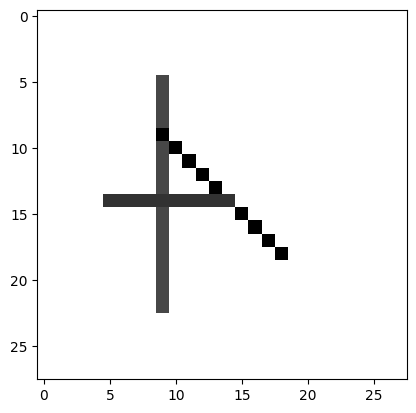


Predicted class is 'four'

Saving trained model state

End MNIST CNN demo 


In [13]:
  plt.tight_layout()
  plt.imshow(x, cmap=plt.get_cmap('gray_r'))
  plt.show()

  digits = ['zero', 'one', 'two', 'three', 'four', 'five', 
    'six', 'seven', 'eight', 'nine' ]
  x = x.reshape(1, 1, 28, 28)  # 1 image, 1 channel
  x = T.tensor(x, dtype=T.float32).to(device)
  with T.no_grad():
    oupt = net(x)  # 10 logits like [[-0.12, 1.03, . . ]]
  am = T.argmax(oupt) # 0 to 9
  print("\nPredicted class is \'" + digits[am] + "\'")

  # 6. save model
  print("\nSaving trained model state")
  fn = "mnist_model.pt"
  T.save(net.state_dict(), fn)  

  print("\nEnd MNIST CNN demo ")